In [77]:
# import libraries
print('importing libraries')
import os, glob, sys, pathlib, shutil
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import multicomp
import matplotlib.pyplot as plt
import seaborn as sns
# add local library
lib = '/Users/connylin/Dropbox/CA/_Publications/Manuscript RL Alcohol hab model slo1/rankinlab_slo1paper/2-Materials-Methods/local_lib'
if lib not in sys.path:
    sys.path.insert(1, lib)
import etl, stats, graphpack

# set local variables --
print('set variables')
# paths for data
DATA_DIR = '/Users/connylin/Dropbox/CA/_Publications/Manuscript RL Alcohol hab model slo1/rankinlab_slo1paper/3-Results/Fig5-slo1 cell specific ko/data'
SUB_DIR = 'Dance_rType2'
PRJ_TAG = 'last3taps' 
MEASURES = ['AccProb']
ANOVA_STRING = 'strain + dose + strain:dose'
pvlimit = 0.001
alpha = 0.05
independent_variable = 'groupname'
# get strain folder
strain_dirs = glob.glob(os.path.join(DATA_DIR, '*', SUB_DIR))

importing libraries
set variables




Processing: HKK796
excel file written
<AccProb>
--ANOVA--
	strain: F(1)=11.471, p=0.002
	dose: F(1)=413.543, p<0.001
	strain:dose: F(1)=1.616, p=n.s.
--Tukey HSD posthoc--
		HKK796 vs HKK796_400mM, p=0.001
		HKK796 vs N2, p=0.011
		HKK796 vs N2_400mM, p=0.001
		HKK796_400mM vs N2, p=0.001
		HKK796_400mM vs N2_400mM, p=n.s.
		N2 vs N2_400mM, p=0.001


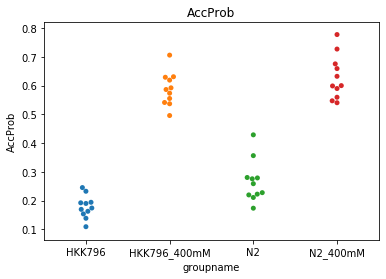


HKK796 complete


Processing: HKK1165
excel file written
<AccProb>
--ANOVA--
	strain: F(1)=9.296, p=0.004
	dose: F(1)=149.514, p<0.001
	strain:dose: F(1)=97.859, p<0.001
--Tukey HSD posthoc--
		HKK1165 vs HKK1165_400mM, p=n.s.
		HKK1165 vs HKK796, p=0.001
		HKK1165 vs HKK796_400mM, p=0.001
		HKK1165_400mM vs HKK796, p=0.001
		HKK1165_400mM vs HKK796_400mM, p=0.001
		HKK796 vs HKK796_400mM, p=0.001


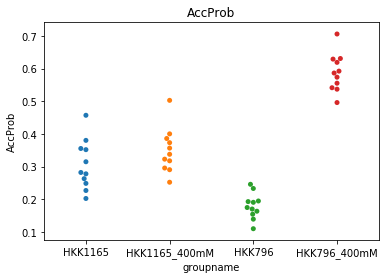


HKK1165 complete


Processing: VG903
excel file written
<AccProb>
--ANOVA--
	strain: F(1)=60.852, p<0.001
	dose: F(1)=551.767, p<0.001
	strain:dose: F(1)=18.716, p<0.001
--Tukey HSD posthoc--
		HKK796 vs HKK796_400mM, p=0.001
		HKK796 vs VG903, p=n.s.
		HKK796 vs VG903_400mM, p=0.001
		HKK796_400mM vs VG903, p=0.001
		HKK796_400mM vs VG903_400mM, p=0.001
		VG903 vs VG903_400mM, p=0.001


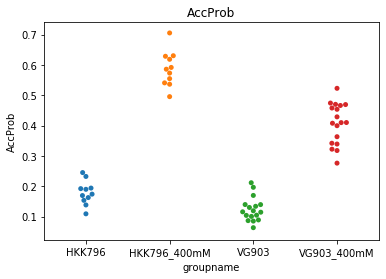


VG903 complete


Processing: VG902
excel file written
<AccProb>
--ANOVA--
	strain: F(1)=4.305, p=0.043
	dose: F(1)=391.076, p<0.001
	strain:dose: F(1)=5.630, p=0.021
--Tukey HSD posthoc--
		HKK796 vs HKK796_400mM, p=0.001
		HKK796 vs VG902, p=0.014
		HKK796 vs VG902_400mM, p=0.001
		HKK796_400mM vs VG902, p=0.001
		HKK796_400mM vs VG902_400mM, p=n.s.
		VG902 vs VG902_400mM, p=0.001


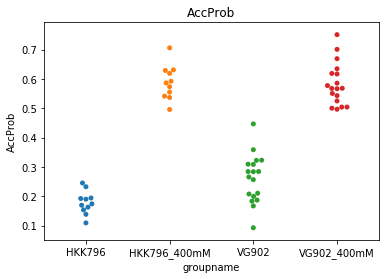


VG902 complete


In [78]:
for strain_dir in strain_dirs:
    # strain info and dirs
    path = pathlib.PurePath(strain_dir)
    strain_name = path.parent.name
    print(f'\n\nProcessing: {strain_name}')
    output_dir = strain_dir

    # load data
    data_path = os.path.join(strain_dir, 'rawdata.csv')
    data = pd.read_csv(data_path)

    # get only N2 data from this set
    if any(data['groupname'] == 'N2'):
        # exp paths for experimental strain
        pathobj = map(lambda x: pathlib.PurePath(x), data['mwtpath'])
        data['exp_path'] = list(map(lambda x: str(x.parent.parent), pathobj))
        exp_path_strain = data.loc[data['groupname'] == strain_name, 'exp_path'].value_counts().index.values
        # find N2 equals to exp strain paths
        data2 = data[data['exp_path'].isin(exp_path_strain)].copy()
        # put aside the old raw data file
        data_path_putaside = os.path.join(strain_dir, 'rawdata_n2fromotherexp.csv')
        shutil.copy(data_path, data_path_putaside)
        # save raw data with only exp N2 in it
        data2.to_csv(data_path, index=False)
        data = data2.copy()
        del data2
    
    # data transformation (get last 3 taps avg per plate)
    data_last3taps = data[data['tap'].isin([28, 29, 30])].copy()
    # drop tap and n 
    data_last3taps.drop(columns=['n','tap'], inplace=True)
    data_last3taps = data_last3taps.groupby(by=['mwtpath','groupname','strain','dose']).agg('mean')
    data_last3taps.reset_index(inplace=True)
    # put it back in main data
    data = data_last3taps.copy()

    # output excel descriptive stats for graphing
    excel_output = data_last3taps.groupby(by='groupname').agg(['count','mean','sem'])
    excel_filepath = os.path.join(strain_dir, 'Last3taps.xlsx')
    with pd.ExcelWriter(excel_filepath) as writer: 
         for msr in MEASURES: 
             excel_output[msr].to_excel(writer, sheet_name=msr)
    print('excel file written')

    # to stats --
    # open text file to record stats output
    filename = os.path.join(output_dir, 'anova_'+PRJ_TAG+'.txt')
    text_file = open(filename, 'w')
    text_file.write(f'ANOVA {PRJ_TAG}\n')
    # run anova, posthoc, swarm plot through each measures
    for msr in MEASURES:
        # write header for text output
        write_string = f'<{msr}>'
        print(write_string)
        text_file.write(write_string)
        write_string = '--ANOVA--'
        print(write_string)
        text_file.write(write_string)
        # run anova 
        ols_equation = f'{msr} ~ {ANOVA_STRING}'
        lm = ols(ols_equation, data).fit()
        anovaT = anova_lm(lm)
        # print ANOVA results
        for factor in anovaT.index[:-1]:
            df = anovaT.loc[factor, 'df']
            F = anovaT.loc[factor, 'F']
            pv = stats.pvalue_string(anovaT.loc[factor, 'PR(>F)'], 
                                    pvlimit, alpha)
            write_string = f'{factor}: F({df:.0f})={F:.3f}, {pv}'
            print(f'\t{write_string}')
            text_file.write(write_string)
        # posthoc (get rid of nan)
        data_no_nan = data[['groupname', msr]].dropna()
        r = multicomp.pairwise_tukeyhsd(data_no_nan[msr], 
                                        data_no_nan['groupname'])
        # print posthoc results
        write_string = '--Tukey HSD posthoc--'
        print(write_string)
        text_file.write(write_string)
        df = pd.DataFrame(data=r._results_table.data[1:], 
                            columns=r._results_table.data[0])
        for i in df.index.values:
            g1 = df.loc[i, 'group1']
            g2 = df.loc[i, 'group2']
            pv = stats.pvalue_string(df.loc[i, 'p-adj'], pvlimit, alpha)
            write_string = f'\t{g1} vs {g2}, {pv}'
            print(f'\t{write_string}')
            text_file.write(write_string)
        
        # swarm plot --
        # make graph
        plt.figure()
        sns.swarmplot(x='groupname',y=msr,data=data)
        plt.title(msr)
        # construct save path
        savefname = f'{msr}_swarmplot_{PRJ_TAG}.jpeg'
        savepath = os.path.join(output_dir, savefname)
        # save fig
        plt.savefig(savepath)
        plt.show() 
        plt.close()
    # finish text export
    text_file.close()
    print(f'\n{strain_name} complete')
    print('=============================================')